In [1]:
import random
import nni
import numpy as np

import io
import graphviz
import matplotlib.pyplot as plt
from PIL import Image

import json
import os

from tqdm.notebook import tqdm

In [2]:
N_MODELS = 1000 #количество сгенерированных моделей

DARTS_OPS = [
        # 'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

Создание архитектуры

In [3]:
def extract_cells(arch_dict):
    normal_cell = {}
    reduction_cell = {}
    
    for key, value in arch_dict.items():
        if key.startswith('normal/'):
            normal_cell[key] = value
        elif key.startswith('reduce/'):
            reduction_cell[key] = value
    
    return normal_cell, reduction_cell

def generate_cells(num_nodes, name='normal', operations=DARTS_OPS):
    cells = dict()
    for i in range(num_nodes - 1):
        cur_indexes = list(range(0, i + 2))
        random_op_0, random_op_1 = random.choices(operations, k=2)
        
        random_index_0, random_index_1 = random.sample(cur_indexes, k=2)
        
        op_str_0 = f'{name}/op_{i + 2}_0'
        op_str_1 = f'{name}/op_{i + 2}_1'
        input_str_0 = f'{name}/input_{i + 2}_0'
        input_str_1 = f'{name}/input_{i + 2}_1'
        
        cells[op_str_0] = random_op_0
        cells[input_str_0] = [random_index_0]
        cells[op_str_1] = random_op_1
        cells[input_str_1] = [random_index_1]
        
    return cells

Визуализация

In [49]:
# Constants for consistent sizing and font
NODE_WIDTH = "1.2"        # fixed width for nodes
NODE_HEIGHT = "0.6"       # fixed height for nodes
FONT_SIZE = "20"          # font size for nodes and edges
FIG_CELL_SIZE = (20, 20)    # size for each cell subplot (width, height)
SPACING = 0.2               # spacing between subplots


def plot_single_cell(arch_dict, cell_name):
    # configure graph with consistent node and font sizes
    g = graphviz.Digraph(
        graph_attr={
            'rankdir': 'LR',
            'nodesep': '0.6',
            'ranksep': '0.6',
        },
        node_attr={
            'style': 'filled',
            'shape': 'rect',
            'align': 'center',
            'fixedsize': 'true',
            'width': NODE_WIDTH,
            'height': NODE_HEIGHT,
            'fontsize': FONT_SIZE,
        },
        edge_attr={
            'splines': 'polyline',
            'fontsize': FONT_SIZE,
        },
        format="png",
    )

    # input nodes
    g.node("c_{k-2}", fillcolor="darkseagreen2")
    g.node("c_{k-1}", fillcolor="darkseagreen2")

    # determine number of intermediate nodes
    max_nodes = max(
        int(key.split("_")[1])
        for key in arch_dict
        if key.startswith(f"{cell_name}/op_")
    )

    # create intermediate nodes
    for i in range(2, max_nodes + 1):
        g.node(str(i), fillcolor="lightblue")

    # add operation edges
    for i in range(2, max_nodes + 1):
        for j in range(2):
            op = arch_dict[f"{cell_name}/op_{i}_{j}"]
            src = arch_dict[f"{cell_name}/input_{i}_{j}"]

            # choose correct source node label
            if src == [0]:
                u = "c_{k-2}"
            elif src == [1]:
                u = "c_{k-1}"
            else:
                u = str(src[0])
            v = str(i)
            g.edge(u, v, label=op, fillcolor="gray")

    # output node
    g.node("c_{k}", fillcolor="palegoldenrod")
    for i in range(2, max_nodes + 1):
        g.edge(str(i), "c_{k}", fillcolor="gray")

    # label the cell
    label = "Reduction cell" if cell_name == "reduce" else f"{cell_name.capitalize()} cell"
    g.attr(label=label, labelloc="t", fontsize=FONT_SIZE)

    # render and return image
    image = Image.open(io.BytesIO(g.pipe()))
    return image


def plot_cells(arch_dict, cell_names):
    images = [plot_single_cell(arch_dict, name) for name in cell_names]

    # set up subplots with identical size per cell
    num = len(images)
    fig, axs = plt.subplots(1, num, figsize=(FIG_CELL_SIZE[0] * num, FIG_CELL_SIZE[1]))
    if num == 1:
        axs = [axs]

    # adjust spacing between cells
    fig.subplots_adjust(wspace=SPACING)

    for ax, img in zip(axs, images):
        ax.imshow(img)
        ax.axis("off")

    plt.show()

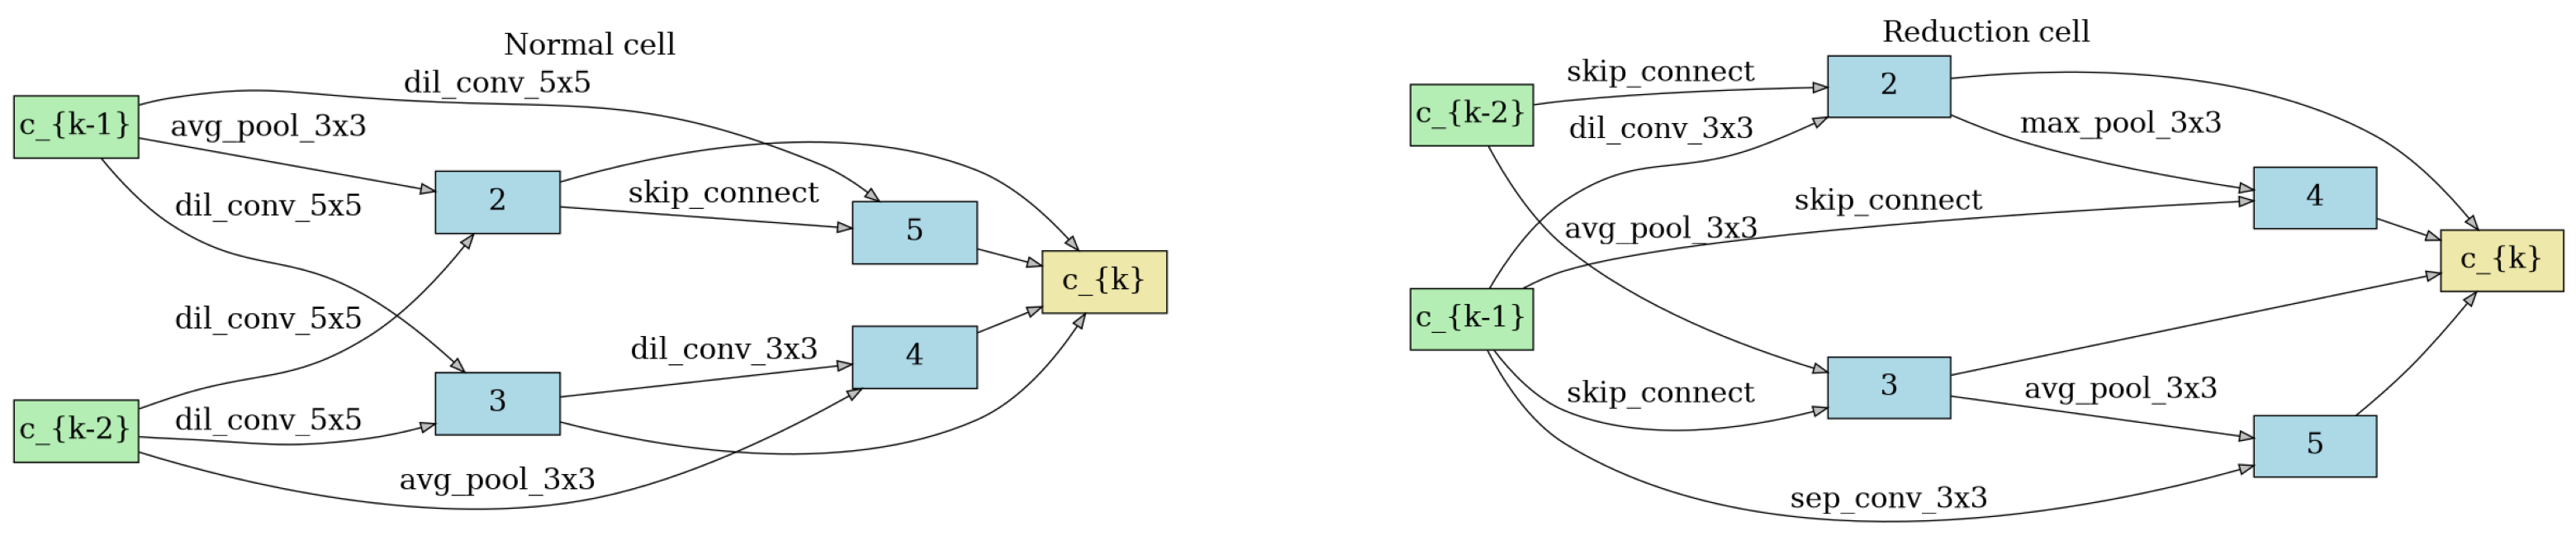

In [51]:
normal_cell = generate_cells(5, name='normal')
reduction_cell = generate_cells(5, name='reduce')
arch_dict = {**normal_cell, **reduction_cell}
plot_cells(arch_dict, ['normal', 'reduce'])

Создание архитектур.

In [6]:
save_directory = 'dataset'

os.makedirs(save_directory, exist_ok=True)

arch_dicts = []
for _ in tqdm(range(N_MODELS)):
    normal_cell = generate_cells(5, name='normal')
    reduction_cell = generate_cells(5, name='reduce')
    arch_dict = {**normal_cell, **reduction_cell}
    arch_dicts.append(arch_dict)

# Save to JSON file in the dataset directory
with open('dataset/arch_dicts.json', 'w') as f:
    json.dump(arch_dicts, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
abort()

NameError: name 'abort' is not defined

Загружает датасет

In [ ]:
def load_arch_dicts(json_path):
    with open(json_path, 'r') as f:
        arch_dicts = json.load(f)
    return arch_dicts

# Пример использования:
arch_dict = load_arch_dicts('dataset/arch_dicts.json')
arch_dict

[{'normal/op_2_0': 'dil_conv_3x3',
  'normal/input_2_0': [0],
  'normal/op_2_1': 'skip_connect',
  'normal/input_2_1': [1],
  'normal/op_3_0': 'dil_conv_3x3',
  'normal/input_3_0': [1],
  'normal/op_3_1': 'dil_conv_5x5',
  'normal/input_3_1': [0],
  'normal/op_4_0': 'skip_connect',
  'normal/input_4_0': [1],
  'normal/op_4_1': 'sep_conv_3x3',
  'normal/input_4_1': [0],
  'normal/op_5_0': 'skip_connect',
  'normal/input_5_0': [2],
  'normal/op_5_1': 'skip_connect',
  'normal/input_5_1': [3],
  'reduce/op_2_0': 'sep_conv_5x5',
  'reduce/input_2_0': [1],
  'reduce/op_2_1': 'dil_conv_3x3',
  'reduce/input_2_1': [0],
  'reduce/op_3_0': 'sep_conv_5x5',
  'reduce/input_3_0': [1],
  'reduce/op_3_1': 'dil_conv_3x3',
  'reduce/input_3_1': [0],
  'reduce/op_4_0': 'avg_pool_3x3',
  'reduce/input_4_0': [1],
  'reduce/op_4_1': 'skip_connect',
  'reduce/input_4_1': [3],
  'reduce/op_5_0': 'avg_pool_3x3',
  'reduce/input_5_0': [4],
  'reduce/op_5_1': 'dil_conv_3x3',
  'reduce/input_5_1': [2]},
 {'norm

In [ ]:
tmp_dict = load_arch_dicts("models_dict_1_architecture.json")

In [ ]:
def plot_combined_cells(arch_dict):
    g = graphviz.Digraph(
        node_attr=dict(
            style="filled",
            shape="rect",
            align="center",
            width="1.5",
            height="1",
            fontsize="28",  # Увеличено на 4
        ),
        edge_attr=dict(
            splines="polyline", penwidth="3", fontsize="24"
        ),
        format="png",
    )

    g.attr(rankdir="LR", overlap="false", splines="true", nodesep="1", ranksep="1")

    g.node("c_{k-2}", label="c_{k-2}", fillcolor="darkseagreen2", fontsize="24")  # Увеличено на 4
    g.node("c_{k-1}", label="c_{k-1}", fillcolor="darkseagreen2", fontsize="24")  # Увеличено на 4

    normal_keys = [key for key in arch_dict if key.startswith("normal/op_")]
    max_nodes_normal = max(int(key.split("_")[1]) for key in normal_keys)

    for i in range(2, max_nodes_normal + 1):
        g.node(f"normal_{i}", label=str(i), fillcolor="lightblue", fontsize="24")  # Увеличено на 4

    for i in range(2, max_nodes_normal + 1):
        for j in range(2):
            op = arch_dict[f"normal/op_{i}_{j}"]
            from_val = arch_dict[f"normal/input_{i}_{j}"]

            if from_val == [0]:
                u = "c_{k-2}"
            elif from_val == [1]:
                u = "c_{k-1}"
            else:
                u = f"normal_{from_val[0]}"
            v = f"normal_{i}"
            g.edge(u, v, label=op, fontsize="24")

    g.node("c_{k}", label="c_{k}", fillcolor="palegoldenrod", fontsize="24")  # Увеличено на 4
    for i in range(2, max_nodes_normal + 1):
        g.edge(f"normal_{i}", "c_{k}")

    reduce_keys = [key for key in arch_dict if key.startswith("reduce/op_")]
    max_nodes_reduce = max(int(key.split("_")[1]) for key in reduce_keys)

    for i in range(2, max_nodes_reduce + 1):
        g.node(f"reduce_{i}", label=str(i + 5), fillcolor="lightcoral", fontsize="24")  # Увеличено на 4

    for i in range(2, max_nodes_reduce + 1):
        for j in range(2):
            op = arch_dict[f"reduce/op_{i}_{j}"]
            from_val = arch_dict[f"reduce/input_{i}_{j}"]

            if from_val == [0]:
                u = "c_{k-1}"
            elif from_val == [1]:
                u = "c_{k}"
            else:
                u = f"reduce_{from_val[0]}"
            v = f"reduce_{i}"
            g.edge(u, v, label=op, fontsize="24")

    g.node("c_{k+1}", label="c_{k+1}", fillcolor="palegoldenrod", fontsize="24")  # Увеличено на 4
    for i in range(2, max_nodes_reduce + 1):
        g.edge(f"reduce_{i}", "c_{k+1}")

    g.attr(size="60,60!")

    image = Image.open(io.BytesIO(g.pipe()))
    return image


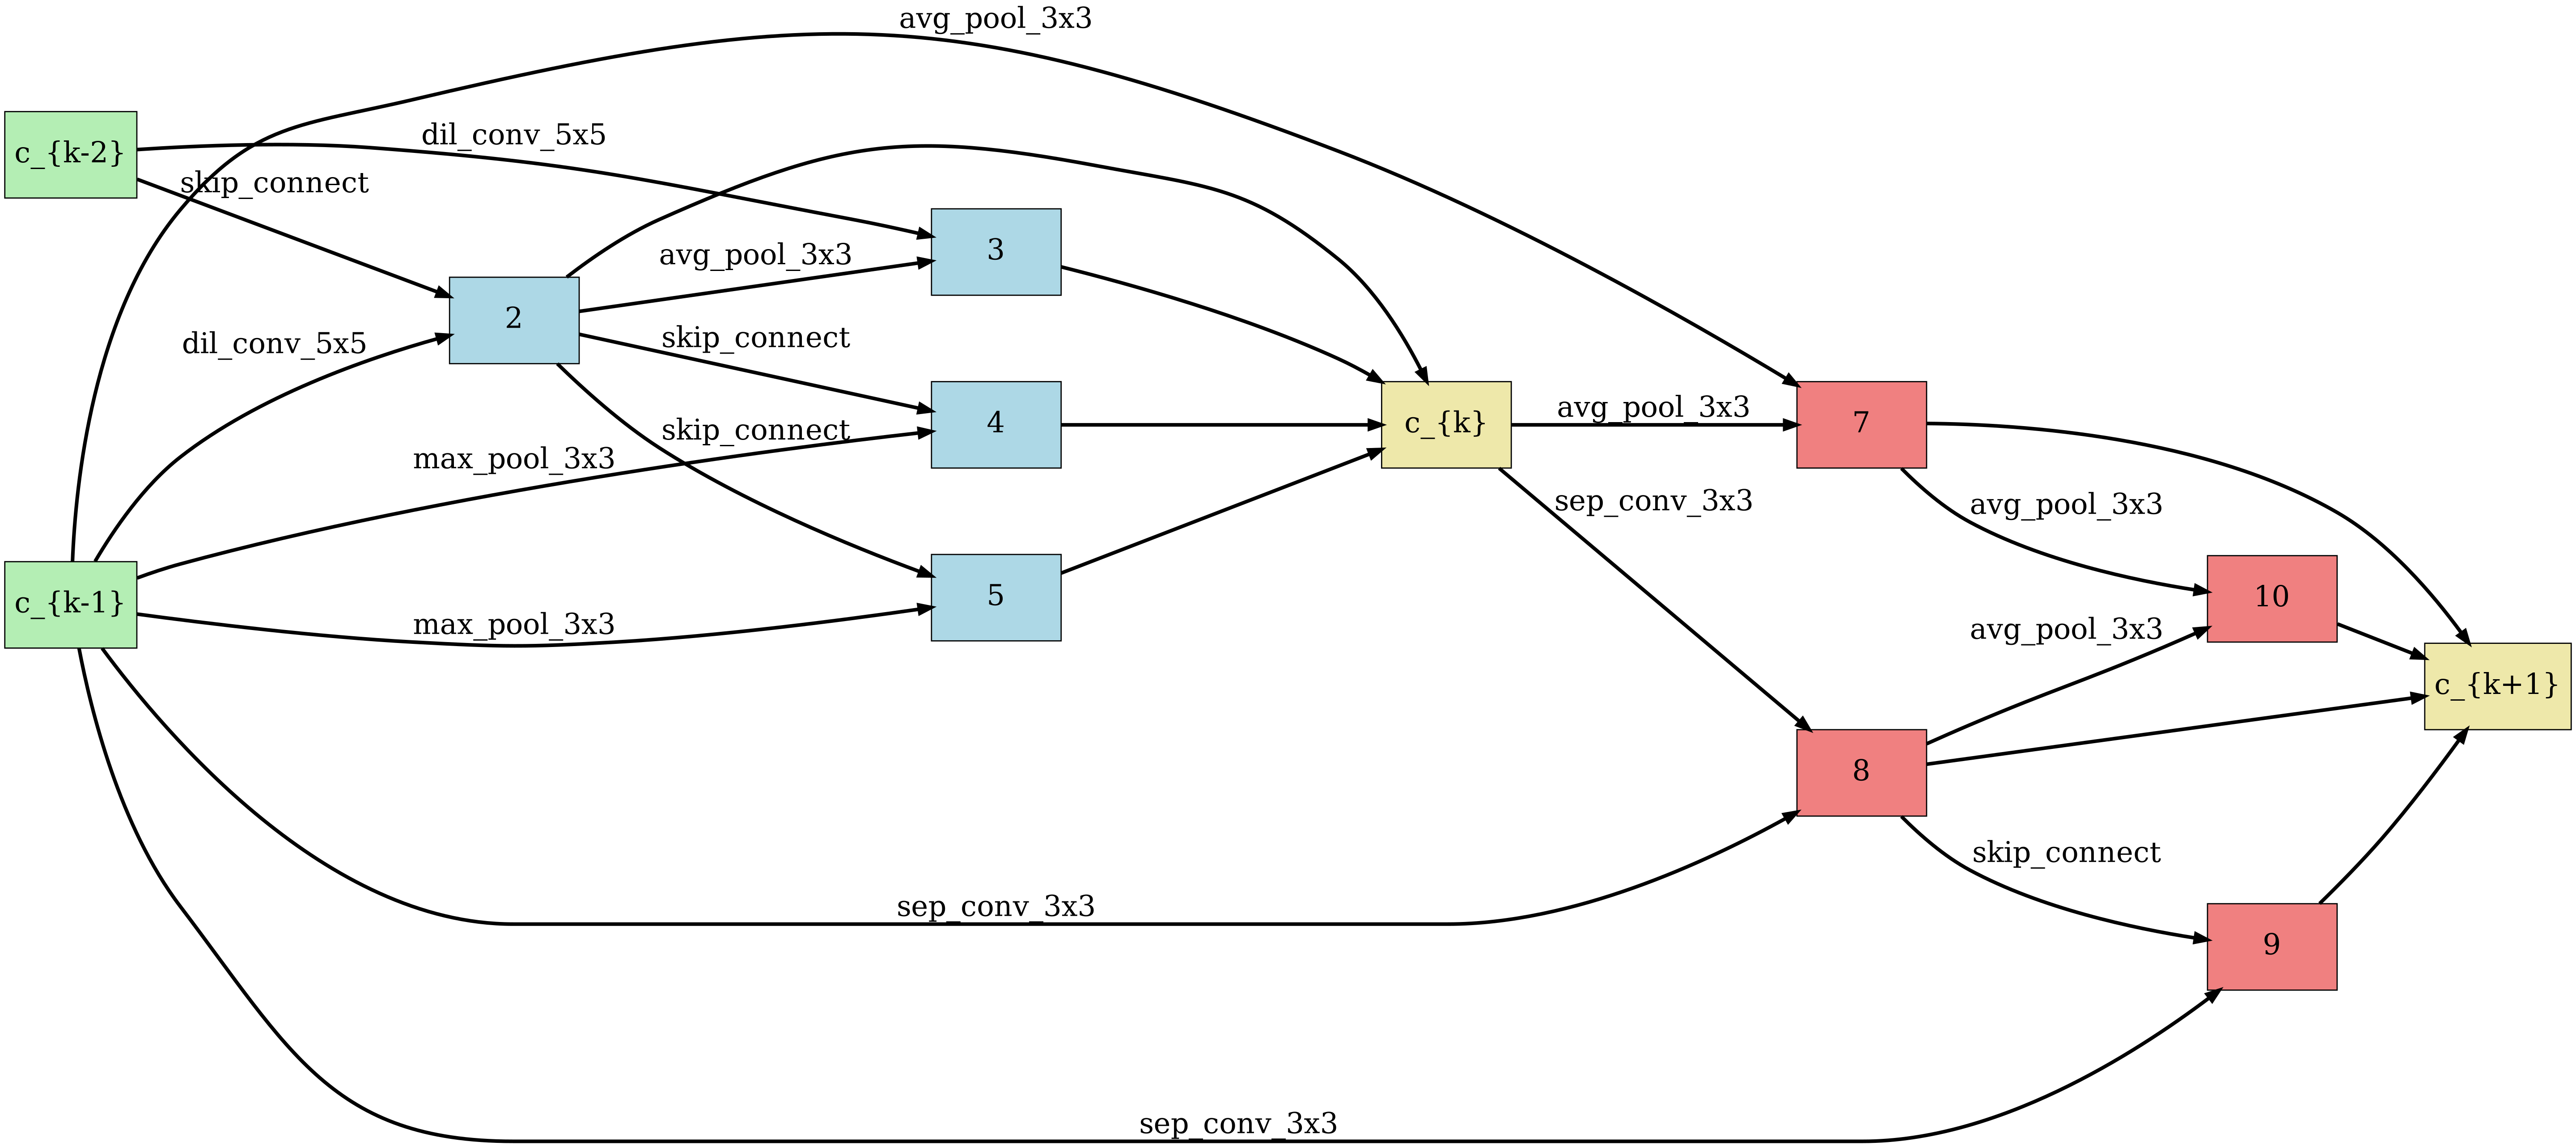

In [ ]:
plot_combined_cells(tmp_dict)